# W2V MLP

### Imports

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import optuna
import random

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from spacy.lang.de.stop_words import STOP_WORDS

import mlflow
import mlflow.pytorch

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# If using CUDA
torch.cuda.manual_seed_all(seed)

# Define experiment
mlflow.set_experiment("W2V")
mlflow.pytorch.autolog()

BENCHMARK_TABLE = "../../class_bench.parquet"

%load_ext autoreload
%autoreload 2

/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### all functions

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)
import time
import os
import torch.serialization
import pickle


class LanguageModelNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_classes):
        super(LanguageModelNN, self).__init__()

        self.fc1 = nn.Linear(embedding_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class LanguageModelNN_Dropout(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(100, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


class TextDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(
            self.y[idx], dtype=torch.long
        )


def train_mlp(model, train_loader, loss_fn, optimizer, num_epochs=10):
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f}s")
    return total_time


def validate_mlp(model, val_loader, label_encoder, training_time=None):
    """
    Validate the MLP model using validation data.

    Args:
        model: The trained MLP model
        val_loader: The validation data loader
        label_encoder: The label encoder used for the model
        training_time: Optional training time for reporting total time

    Returns:
        tuple: (recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc)
    """
    model.eval()
    start_time = time.time()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            probs = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Convert numeric labels to class names (centuries)
    all_labels_original = label_encoder.inverse_transform(all_labels)
    all_predictions_original = label_encoder.inverse_transform(all_predictions)

    # 1. Basic Metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision_avg = precision_score(all_labels, all_predictions, average="weighted")
    recall_avg = recall_score(all_labels, all_predictions, average="weighted")
    f1_score_avg = f1_score(all_labels, all_predictions, average="weighted")

    # 2. Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=label_encoder.classes_)
    cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

    # 3. Specificity (True Negative Rate)
    specificity = []
    for i in range(len(label_encoder.classes_)):
        tn = np.sum((all_labels != i) & (all_predictions != i))
        fp = np.sum((all_labels != i) & (all_predictions == i))
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    avg_specificity = np.mean(specificity)

    # 4. ROC and AUC
    # Calculate ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # One-vs-Rest ROC curves
    for i in range(len(label_encoder.classes_)):
        # Convert to binary classification for each class
        y_true_binary = (all_labels == i).astype(int)
        y_score = all_probs[:, i]

        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculate micro-average ROC curve and ROC area
    # First, binarize the labels
    y_true_bin = np.zeros((len(all_labels), len(label_encoder.classes_)))
    for i in range(len(all_labels)):
        y_true_bin[i, all_labels[i]] = 1

    # Calculate micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    avg_roc = roc_auc["micro"]

    validation_time = time.time() - start_time

    # Print metrics
    print("\n=== Validation Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision_avg:.4f}")
    print(f"Recall: {recall_avg:.4f}")
    print(f"F1-Score: {f1_score_avg:.4f}")
    print(f"Specificity: {avg_specificity:.4f}")
    print(f"AUC (micro): {avg_roc:.4f}")
    print(f"Validation time: {validation_time:.2f}s")
    if training_time is not None:
        print(f"Training time: {training_time:.2f}s")
        print(f"Total time (train + validate): {training_time + validation_time:.2f}s")

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_percentage,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (%)")
    plt.show()

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (area = {avg_roc:.2f})",
    )

    for i in range(len(label_encoder.classes_)):
        plt.plot(
            fpr[i],
            tpr[i],
            label=f"ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})",
        )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves")
    plt.legend(loc="lower right")
    plt.show()

    # Print Classification Report
    print("\n=== Classification Report ===")
    report = classification_report(
        all_labels_original,
        all_predictions_original,
        target_names=[str(c) for c in label_encoder.classes_],
    )
    print(report)

    return recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc


def save_mlp(
    model,
    label_encoder,
    val_loader,
    training_time,
    model_path="model/saved/mlp_model.pkl",
):
    """
    Save the MLP model and its metadata using pickle format.

    Args:
        model: The trained MLP model to save
        label_encoder: The label encoder used for the model
        val_loader: The validation data loader
        training_time: The training time in seconds
        model_path: Path where to save the model (default: model/saved/mlp_model.pkl)
    """
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(model_path), exist_ok=True)

    # Extract data from val_loader
    val_data = []
    val_labels = []
    for X, y in val_loader:
        val_data.append(X.numpy())
        val_labels.append(y.numpy())
    val_data = np.concatenate(val_data)
    val_labels = np.concatenate(val_labels)

    # Prepare data to save
    save_data = {
        "model_state_dict": model.state_dict(),
        "label_encoder": label_encoder,
        "val_data": val_data,
        "val_labels": val_labels,
        "training_time": training_time,
        "model_config": {
            "embedding_dim": model.fc1.in_features,
            "hidden_size": model.fc1.out_features,
            "num_classes": model.fc2.out_features,
            "dropout": model.dropout.p if hasattr(model, "dropout") else 0.0,
        },
    }

    # Save using pickle
    with open(model_path, "wb") as f:
        pickle.dump(save_data, f)
    print(f"MLP model saved successfully to {model_path}")


def load_mlp(model_path="model/saved/mlp_model.pkl"):
    """
    Load a saved MLP model and its metadata from pickle format.

    Args:
        model_path: Path to the saved model (default: model/saved/mlp_model.pkl)

    Returns:
        tuple: (model, label_encoder, val_loader, config, training_time)
    """
    # Load checkpoint using pickle
    with open(model_path, "rb") as f:
        checkpoint = pickle.load(f)

    # Create model with saved configuration
    config = checkpoint["model_config"]

    # Determine which model class to use based on dropout
    if config["dropout"] > 0:
        model = LanguageModelNN_Dropout(
            num_classes=config["num_classes"], dropout=config["dropout"]
        )
    else:
        model = LanguageModelNN(
            embedding_dim=config["embedding_dim"],
            hidden_size=config["hidden_size"],
            num_classes=config["num_classes"],
        )

    # Load model weights
    model.load_state_dict(checkpoint["model_state_dict"])

    # Load label encoder
    label_encoder = checkpoint["label_encoder"]

    # Recreate validation dataset and loader
    val_dataset = TextDataset(checkpoint["val_data"], checkpoint["val_labels"])
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=32,  # You might want to save this as part of the config
        shuffle=False,
    )

    # Get training time
    training_time = checkpoint.get("training_time", None)

    return model, label_encoder, val_loader, config, training_time


### Loading data into a Dataframe (df)

In [3]:
df = pd.read_parquet("../data/de_poems.parquet")
df = df.astype(
    {"title": "string", "text": "string", "author": "string", "creation": "int64"}
)
df.dtypes


title       string[python]
text        string[python]
author      string[python]
creation             int64
dtype: object

In [4]:
# Convertir les dates en siècles, en gérant les valeurs None
# D'abord, créer une copie pour ne pas modifier l'original
df_siecles = df.copy()

# Convertir uniquement les valeurs non-nulles en entiers puis en siècles
# Assurons-nous que toutes les valeurs sont soit des nombres, soit des NaN
df_siecles["creation"] = pd.to_numeric(df_siecles["creation"], errors="coerce")

# Maintenant, appliquer la conversion en siècles seulement sur les valeurs non-nulles
mask = df_siecles["creation"].notna()
df_siecles.loc[mask, "creation"] = df_siecles.loc[mask, "creation"].apply(
    lambda x: (x - 1) // 100 + 1
)

# Remplacer df par df_siecles pour conserver les modifications
df = df_siecles

In [5]:
# Filtrer les lignes où creation est None
df_none_creation = df[df["creation"].isnull()]


# Grouper par author pour voir combien de poèmes chaque author a avec creation = None
authors_avec_none = (
    df_none_creation.groupby("author").size().sort_values(ascending=False)
)

# Pour chaque author ayant des poèmes sans date, vérifier s'il a aussi des poèmes avec date
authors_a_corriger = []
for author in df_none_creation["author"].unique():
    dates_disponibles = df[df["author"] == author]["creation"].dropna().unique()
    if len(dates_disponibles) > 0:
        authors_a_corriger.append((author, dates_disponibles))


# Fonction pour remplir les dates manquantes avec la médiane des dates de l'author
def remplir_dates_manquantes(df):
    df_copy = df.copy()

    for author in df[df["creation"].isna()]["author"].unique():
        dates = df[df["author"] == author]["creation"].dropna()
        if len(dates) > 0:
            # Utiliser la médiane des dates disponibles pour cet author
            date_mediane = int(np.median(dates))
            # Remplir les valeurs manquantes pour cet author
            mask = (df_copy["author"] == author) & (df_copy["creation"].isna())
            df_copy.loc[mask, "creation"] = date_mediane

    return df_copy


# Appliquer la fonction pour remplir les dates manquantes
df_corrige = remplir_dates_manquantes(df)

# Vérifier combien de dates ont été corrigées
nb_corriges = len(df) - df_corrige["creation"].isna().sum()
nb_restants = df_corrige["creation"].isna().sum()

print(f"\nNombre de dates corrigées: {nb_corriges - (len(df) - len(df_none_creation))}")
print(f"Nombre de poèmes restants sans date: {nb_restants}")

df = df_corrige.dropna()


Nombre de dates corrigées: 0
Nombre de poèmes restants sans date: 0


### Tokenizing text

#### Spacy

In [14]:
nlp = spacy.load("de_core_news_sm")
# python -m spacy download de_core_news_sm


def preprocess_text_spacy(doc):
    tokens = [token.lemma_ for token in doc if not token.is_punct]
    return tokens


def preprocess_text_spacy_stopwords(doc):
    filtered_tokens = [
        token.lemma_
        for token in doc
        if not token.is_punct and token.lemma_.lower() not in STOP_WORDS
    ]
    return filtered_tokens


In [15]:
texts = df["text"].tolist()
docs = list(nlp.pipe(texts, batch_size=1000, n_process=4))

df["tokens"] = [preprocess_text_spacy_stopwords(doc) for doc in docs]

In [26]:
df.to_pickle("spacy_tokenized.pkl")

In [4]:
df = pd.read_pickle("../../multi_layer_perceptron/spacy_tokenized.pkl")

### Training Word 2 Vec on the tokenized texts

In [ ]:
tokenized_poems = df["tokens"].tolist()
model_df = Word2Vec(tokenized_poems, vector_size=100, window=5, min_count=2, workers=4)

model_df.save("word2vec_df.model")

#### W2V Boosted

In [35]:
model_df = Word2Vec(
    sentences=df["tokens"],
    vector_size=500,
    window=20,
    min_count=2,
    workers=32,
    epochs=50,
    seed=42,
)

model_df.save("word2vec_boosted2.model")

In [5]:
model_df = Word2Vec.load("../../multi_layer_perceptron/word2vec_boosted2.model")

### Embedding Text && Encoding Century

In [ ]:
def text_to_embedding(tokens, model, embedding_dim=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(embedding_dim)
    return np.mean(vectors, axis=0)

def vectorize(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size * 2)
    vectors = np.array(vectors)
    mean_vec = vectors.mean(axis=0)
    max_vec = vectors.max(axis=0)
    return np.concatenate([mean_vec, max_vec])


df["embedding"] = df["tokens"].apply(lambda x: text_to_embedding(x, model_df))
#df["embedding"] = df["tokens"].apply(lambda x: vectorize(x, model_df))

In [7]:
from sklearn.preprocessing import StandardScaler

label_encoder = LabelEncoder()
df.loc[:, "creation"] = label_encoder.fit_transform(df["creation"])

x = torch.tensor(np.stack(df["embedding"].values), dtype=torch.float32)
y = torch.tensor(df["creation"].values, dtype=torch.long)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

## MLP

### Creating the data loaders

In [20]:
train_dataset = TextDataset(x_train, y_train)
val_dataset = TextDataset(x_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Creating model and hyperparameters

In [21]:
embedding_dim = 500
hidden_size = 128
num_classes = len(df["century_label"].unique())

class_counts = np.bincount(df["century_label"])
class_weights = 1.0 / class_counts

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = LanguageModelNN(embedding_dim, hidden_size, num_classes)
# model = LanguageModelNN_Dropout(num_classes)
model.apply(initialize_weights)

loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)


### Training and Validating model

In [22]:
mlflow.end_run()    
mlp_training_time = train_mlp(model, train_loader, loss_fn, optimizer, num_epochs=200)

/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/multi_layer_perceptron/model/mlp.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(


Epoch 1/200, Loss: 0.5604
Epoch 2/200, Loss: 0.4201
Epoch 3/200, Loss: 0.3657
Epoch 4/200, Loss: 0.3225
Epoch 5/200, Loss: 0.2863
Epoch 6/200, Loss: 0.2576
Epoch 7/200, Loss: 0.2346
Epoch 8/200, Loss: 0.2110
Epoch 9/200, Loss: 0.1923
Epoch 10/200, Loss: 0.1768
Epoch 11/200, Loss: 0.1626
Epoch 12/200, Loss: 0.1497
Epoch 13/200, Loss: 0.1384
Epoch 14/200, Loss: 0.1281
Epoch 15/200, Loss: 0.1204
Epoch 16/200, Loss: 0.1115
Epoch 17/200, Loss: 0.1032
Epoch 18/200, Loss: 0.0960
Epoch 19/200, Loss: 0.0896
Epoch 20/200, Loss: 0.0881
Epoch 21/200, Loss: 0.0801
Epoch 22/200, Loss: 0.0760
Epoch 23/200, Loss: 0.0746
Epoch 24/200, Loss: 0.0698
Epoch 25/200, Loss: 0.0659
Epoch 26/200, Loss: 0.0643
Epoch 27/200, Loss: 0.0608
Epoch 28/200, Loss: 0.0569
Epoch 29/200, Loss: 0.0597
Epoch 30/200, Loss: 0.0548
Epoch 31/200, Loss: 0.0523
Epoch 32/200, Loss: 0.0553
Epoch 33/200, Loss: 0.0499
Epoch 34/200, Loss: 0.0505
Epoch 35/200, Loss: 0.0477
Epoch 36/200, Loss: 0.0460
Epoch 37/200, Loss: 0.0483
Epoch 38/2

In [28]:
save_mlp(model, label_encoder, val_loader, mlp_training_time, "../classification/trained/MLP_W2V_model.pkl")

MLP model saved successfully to ../classification/trained/MLP_W2V_model.pkl


/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/multi_layer_perceptron/model/mlp.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(


In [6]:
model, label_encoder, val_loader, config, mlp_training_time = load_mlp("../trained/MLP_W2V_model.pkl")

## Evaluation

### Evaluation for MLP Model


=== Validation Metrics ===
Accuracy: 0.8405
Precision: 0.8376
Recall: 0.8405
F1-Score: 0.8386
Specificity: 0.9732
AUC (micro): 0.9830
Validation time: 0.36s


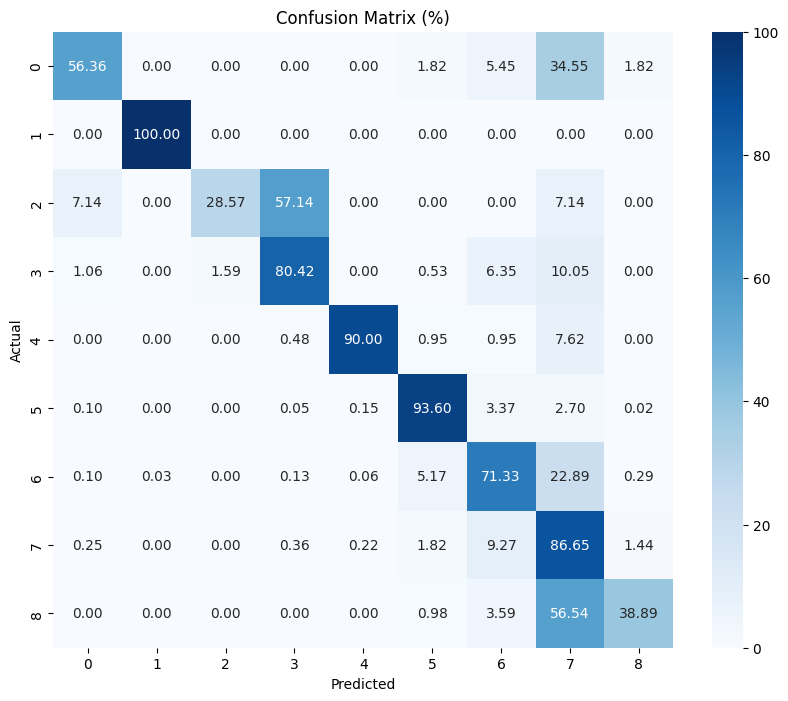

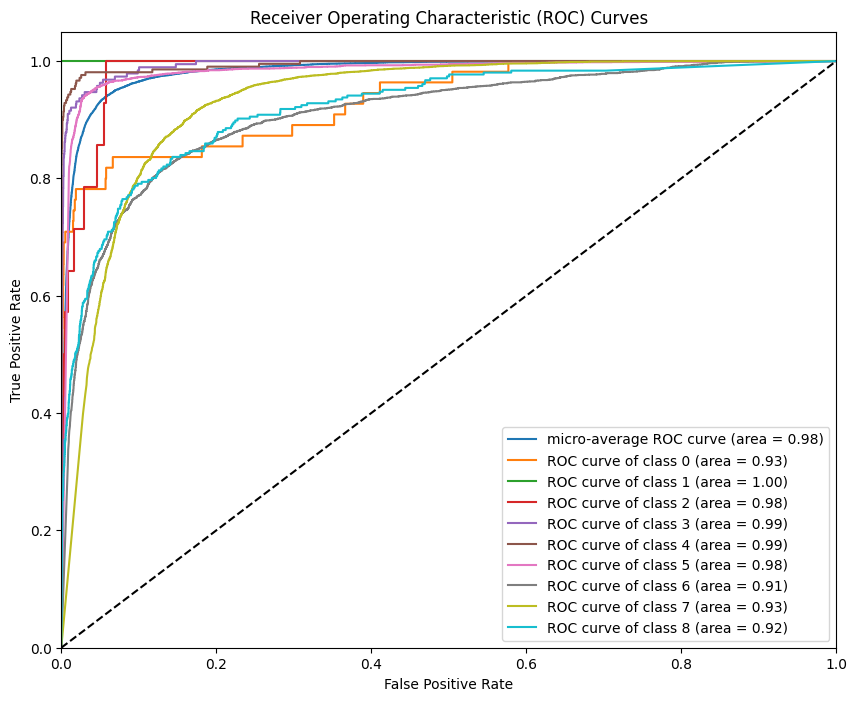


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.54      0.56      0.55        55
           1       0.80      1.00      0.89         4
           2       0.57      0.29      0.38        14
           3       0.80      0.80      0.80       189
           4       0.90      0.90      0.90       210
           5       0.93      0.94      0.93      4032
           6       0.75      0.71      0.73      3115
           7       0.84      0.87      0.85      6389
           8       0.54      0.39      0.45       306

    accuracy                           0.84     14314
   macro avg       0.74      0.72      0.72     14314
weighted avg       0.84      0.84      0.84     14314



In [7]:
recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc = validate_mlp(model, val_loader, label_encoder)

In [8]:
benchmark = pd.read_parquet(BENCHMARK_TABLE)

In [9]:
benchmark

Accuracy  Avg Precision  Avg Recall  \
Encoding Model                                                             
TF-IDF   Logistic Regression         0.803689       0.828462    0.803689   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   
Word2Vec Logistic Regression         0.000000       0.000000    0.000000   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   

                                     Avg F1-Score   Avg AUC  \
Encoding Model                                                
TF-IDF   Logistic Regression             0.812189  0.969342   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   
Word2Vec Logistic Regression             0.000000  0.000000   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   

                                     Avg Training time (m)  
Encoding Model                                              
TF-IDF   Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
Word2Vec Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0

In [ ]:
benchmark.loc[
    ("Word2Vec", "Feedforward Neural Network"),
    ["Avg Recall", "Avg F1-Score", "Avg Precision", "Accuracy", "Avg AUC"],
] = [recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc]


In [11]:
benchmark

Accuracy  Avg Precision  Avg Recall  \
Encoding Model                                                             
TF-IDF   Logistic Regression         0.803689       0.828462    0.803689   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   
Word2Vec Logistic Regression         0.000000       0.000000    0.000000   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   
         Multi-Layer Perceptron      0.840506       0.837564    0.840506   

                                     Avg F1-Score   Avg AUC  \
Encoding Model                                                
TF-IDF   Logistic Regression             0.812189  0.969342   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   
Word2Vec Logistic Regression             0.000000  0.000000   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   
         Multi-Layer Perceptron          0.838563  0.983007   

                                     Avg Training time (m)  
Encoding Model                                              
TF-IDF   Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
Word2Vec Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
         Multi-Layer Perceptron                        NaN

In [12]:
benchmark.to_parquet(BENCHMARK_TABLE, index=True)

## HyperParam Optimization

In [ ]:
def objective(trial):
    # Hyperparameters to optimize
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_choice = trial.suggest_categorical("optimizer", ["Adam", "AdamW"])

    # Model creation with dropout
    model = LanguageModelNN_Dropout(num_classes=num_classes, dropout=dropout_rate)
    model = model.to(device)  # Move model to GPU

    # Dataset & DataLoader
    train_dataset = TextDataset(x_train, y_train)
    val_dataset = TextDataset(x_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    loss_fn = nn.CrossEntropyLoss(reduction="mean")

    # Optimizer selection
    if optimizer_choice == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_choice == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Early stopping parameters
    patience = 100
    best_val_acc = 0
    patience_counter = 0

    # Training
    for epoch in range(50):
        model.train()
        train_losses = []

        for batch_X, batch_y in train_loader:
            # Move tensors to the right device
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Calculate average training loss for the epoch
        avg_train_loss = sum(train_losses) / len(train_losses)

        # Validation
        model.eval()
        all_preds = []
        all_labels = []
        val_losses = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                loss = loss_fn(outputs, batch_y)
                val_losses.append(loss.item())

                preds = torch.argmax(outputs, dim=1)

                # Move back to CPU for numpy conversion
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())

        # Calculate metrics
        current_val_acc = accuracy_score(all_labels, all_preds)
        avg_val_loss = sum(val_losses) / len(val_losses)

        # Log metrics (optional)
        print(
            f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {current_val_acc:.4f}"
        )

        # Report to Optuna for pruning
        trial.report(current_val_acc, epoch)

        # Handle pruning - stop this trial if it's not promising
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Early stopping logic
        if current_val_acc > best_val_acc:
            best_val_acc = current_val_acc
            patience_counter = 0
            # Save best model (optional)
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    # Load best model weights before final evaluation (optional)
    if "best_model_state" in locals():
        model.load_state_dict(best_model_state)

    # Final evaluation on validation set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    final_acc = accuracy_score(all_labels, all_preds)

    return final_acc  # Return the best validation accuracy


def run_optuna_optimization(n_trials=20):
    # Create pruner
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,  # Number of trials to run before pruning
        n_warmup_steps=5,  # Number of epochs in each trial before pruning
        interval_steps=1,  # Report and check for pruning after each epoch
    )

    # Create study with the pruner
    study = optuna.create_study(
        direction="maximize", pruner=pruner, study_name="nlp_model_optimization"
    )

    # Run optimization
    study.optimize(objective, n_trials=n_trials)

    # Print results
    print("\nStudy statistics: ")
    print(f"  Number of finished trials: {len(study.trials)}")
    print(
        f"  Number of pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}"
    )
    print(
        f"  Number of complete trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}"
    )

    print("\nBest trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study


In [ ]:
study = run_optuna_optimization(n_trials=100)

In [ ]:
values = [trial.value for trial in study.trials]

plt.figure(figsize=(10, 6))
plt.plot(values, label="Objective Value")
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.title("Optimization History")
plt.legend()
plt.show()

In [ ]:
importances = optuna.importance.get_param_importances(study)
param_names = list(importances.keys())
importances_df = pd.DataFrame(
    list(importances.items()), columns=["Hyperparameter", "Importance"]
)


plt.figure(figsize=(10, 6))
importances_df.plot(kind="bar", x="Hyperparameter", y="Importance", legend=False)
plt.xlabel("Hyperparameters")
plt.ylabel("Importance")
plt.title("Parameter Importances")
plt.show()

In [ ]:
best_params = study.best_params

final_model = LanguageModelNN_Dropout(
    num_classes=num_classes, dropout=best_params["dropout"]
)
final_model = final_model.to(device)

# Setup with best hyperparameters
if best_params["optimizer"] == "Adam":
    final_optimizer = optim.Adam(final_model.parameters(), lr=best_params["lr"])
else:
    final_optimizer = optim.AdamW(final_model.parameters(), lr=best_params["lr"])

## Pipeline

In [104]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming df['embedding'] is a column of w2v vectors
X = np.vstack(df["embedding"].values)
y = df["century_label"].values

# Split FIRST to avoid data leak
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)



In [105]:
# Define the pipeline
pipe = Pipeline(
    [
        ("smote", SMOTE()),
        ("scale", StandardScaler()),
        ("pca", PCA()),
        (
            "mlp",
            MLPClassifier(
                early_stopping=True, n_iter_no_change=10, max_iter=300, random_state=42
            ),
        ),
    ]
)

# Define hyperparameter grid
param_grid = {
    "pca__n_components": [30, 50, 70],
    "mlp__hidden_layer_sizes": [(64,), (128,), (128, 64)],
    "mlp__alpha": [0.0001, 0.0005, 0.001],
    "mlp__solver": ["adam", "lbfgs"],
    "mlp__activation": ["relu", "tanh"],
}


In [106]:
# Use Stratified CV to tune
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid.fit(X, y)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

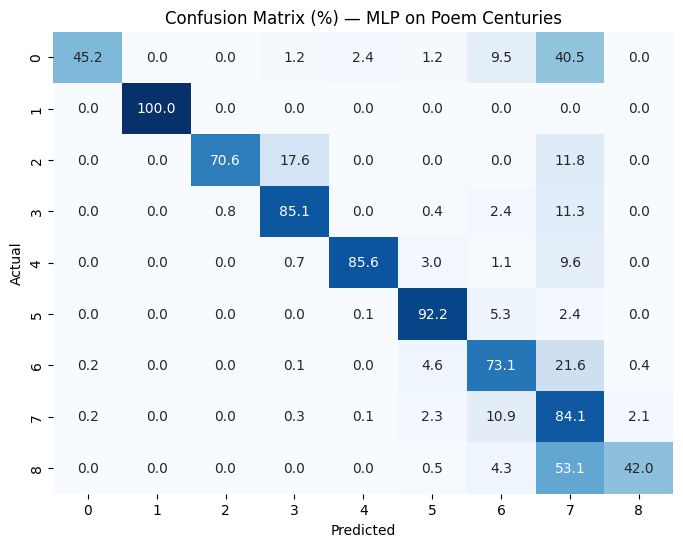

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# After training
y_pred = pipe.predict(X_test)

# Raw confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize rows to get % per actual class
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

# Pretty plot with Seaborn
centuries = sorted(np.unique(y))  # or custom: ['15th', '16th', ...]
df_cm = pd.DataFrame(cm_percent, index=centuries, columns=centuries)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt=".1f", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (%) — MLP on Poem Centuries")
plt.show()

## Geneartion

In [17]:
def generate_poem_for_century(
    century, model, word2vec_model, max_length=50, temperature=0.7
):
    """
    Generate a poem for a specific century using the trained model.

    Args:
        century (int): The target century
        model: The trained MLP model
        word2vec_model: The trained Word2Vec model
        max_length (int): Maximum length of the generated poem
        temperature (float): Controls randomness (higher = more random)
    """
    # Get all words from the vocabulary
    vocabulary = list(word2vec_model.wv.key_to_index.keys())

    # Start with a random word
    current_word = np.random.choice(vocabulary)
    generated_poem = [current_word]

    for _ in range(max_length):
        # Get the word vector for the current word
        if current_word in word2vec_model.wv:
            word_vector = word2vec_model.wv[current_word]

            # Reshape for model input
            input_vector = torch.tensor(word_vector, dtype=torch.float32).unsqueeze(0)

            # Get model prediction
            with torch.no_grad():
                output = model(input_vector)

            # Apply temperature
            output = output / temperature

            # Convert to probabilities
            probs = torch.softmax(output, dim=1)

            # Sample next word based on probabilities
            next_word_idx = torch.multinomial(probs, 1).item()
            next_word = vocabulary[next_word_idx]

            generated_poem.append(next_word)
            current_word = next_word

            # Add some randomness to break repetitive patterns
            if np.random.random() < 0.1:
                current_word = np.random.choice(vocabulary)

    return " ".join(generated_poem)


def format_poem(text, line_length=40):
    """
    Format the generated text into poem-like lines
    """
    words = text.split()
    lines = []
    current_line = []
    current_length = 0

    for word in words:
        if current_length + len(word) + 1 <= line_length:
            current_line.append(word)
            current_length += len(word) + 1
        else:
            lines.append(" ".join(current_line))
            current_line = [word]
            current_length = len(word)

    if current_line:
        lines.append(" ".join(current_line))

    return "\n".join(lines)


In [42]:
# Generate a poem for the 19th century
century = 19
generated_poem = generate_poem_for_century(
    century, model, model_df, max_length=1000
)
formatted_poem = format_poem(generated_poem, line_length=40)
print(f"Generated Poem for the {century}th Century:")
print(formatted_poem)

Generated Poem for the 19th Century:
bespringt nicht in in in in in in in in
in in in in in in in in in nicht in in
in in in in in in in nicht in in in in
in nicht in in den nicht in in in in in
in in in in in in in in in in in in in
in in in in in nicht in in in in in in
in in in in in in in in den nicht in in
in in in in in in in in in in in in in
in in in in in in den nicht in in in in
in in in in in in in in in in in in in
in in in in in in in in in nicht in in
in in den nicht in in in in in in in den
nicht in in in in in in in in in in in
in in in in nicht in in in den nicht in
in in in in in den nicht in in in in in
den nicht in in in in in in nicht in in
den nicht nicht in in in in in in in in
in in in in in in in in in in in den
nicht in nicht in in in in nicht in den
nicht in in in in in in in in in in in
in in in in in in in in in in den nicht
in in in in in in in in in nicht in in
in in in in in in in in in in in in in
in in in in in in in nicht in in in in
in in nicht in in